In [1]:
# Based on https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/03_problem_representation/rebalancing.ipynb.
#   !gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

import xgboost as xgb
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras

In [2]:
SEED = 42
NROWS = None

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
    df = pd.get_dummies(df)

    target = df.isFraud
    df = df.drop(columns=['isFraud'])
    sc = StandardScaler()    
    df[df.columns] = sc.fit_transform(df)
    df['isFraud'] = target
    return df

def fraud_rate_df(df: pd.DataFrame) -> float:
    fraud_df = df[df['isFraud'] == 1]
    return len(fraud_df)/len(df)

def fraud_rate(y) -> float:
    fraud_indices = np.where(y == 1)[0]
    return len(fraud_indices) / len(y) # type: ignore

def train_split(df: pd.DataFrame):
    y = df.isFraud.values
    X_train, X_test, _, y_test = train_test_split(df, y, stratify=y, test_size=0.2, random_state=SEED)
    train_df = pd.DataFrame(data=X_train, columns=df.columns)
    X_test.drop(columns=['isFraud'], inplace=True) # type: ignore
    return train_df, X_test, y_test

# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        # cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
        cm = cm / cm.sum(axis=1, keepdims=True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.3f}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")                 

    plt.tight_layout()  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_and_eval(df: pd.DataFrame, oversampling: bool = False):

    train_df, X_test, y_test = train_split(df)

    X_train = train_df.drop(columns=['isFraud']).values
    y_train = train_df.isFraud.values

    if oversampling:
        X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
    colors = ['#ef8a62' if v == 0 else '#f7f7f7' for v in y_train]
    kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
    #plt.scatter(X_train[:, 1], X_train[:, 2], c=colors, **kwarg_params)
    #sns.despine()

    print(f'Fraud Rate in (all, train, test)=({fraud_rate_df(df):.5f}, {fraud_rate(y_train):.5f}, {fraud_rate(y_test):.5f})')

    model = keras.Sequential([
        keras.layers.Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.reshape(-1).astype(int)
    print(f'label={y_test} pred={y_pred}')
    print(f'accuracy_score: {accuracy_score(y_test, y_pred):.4f}')    
    print(f'precision_score: {precision_score(y_test, y_pred):.4f}')
    print(f'recall_score: {recall_score(y_test, y_pred):.4f}')    
    print(f'f1_score: {f1_score(y_test, y_pred):.4f}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'cm={cm}')

    classes = ['not fraud', 'fraud']    
    plot_confusion_matrix(cm, classes, normalize=True)

In [3]:
df = pd.read_csv('/kaggle/input/fraud_data_kaggle.csv', nrows=NROWS)
df = process_data(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.703042,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0
1,-1.703042,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0
2,-1.703042,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,-0.714778,3.307478,1
3,-1.703042,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,-0.530965,1.357803,-0.08096,-0.714778,-0.302345,1
4,-1.703042,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0


Fraud Rate in (all, train, test)=(0.00129, 0.00129, 0.00129)
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-11-30 17:12:00.790226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-30 17:12:00.790552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-30 17:12:00.991533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-30 17:12:00.993792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-30 17:12:01.123179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 17:13:10.786959: I tensorflow/core/grappler/

label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
accuracy_score: 0.9992
precision_score: 0.9863
recall_score: 0.3956
f1_score: 0.5647
cm=[[1270872       9]
 [    993     650]]


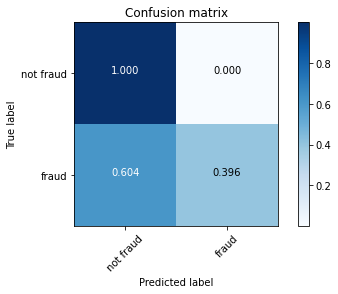

In [4]:
# Use the imblanced train data as is.
train_and_eval(df)

Fraud Rate in (all, train, test)=(0.00129, 0.50000, 0.00129)


2021-11-30 17:46:20.930014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 17:48:43.068927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
accuracy_score: 0.9754
precision_score: 0.0481
recall_score: 0.9592
f1_score: 0.0916
cm=[[1239700   31181]
 [     67    1576]]


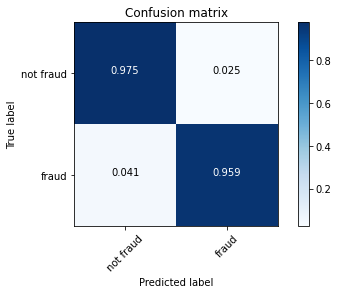

In [5]:
train_and_eval(df, oversampling=True)